In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sionna.phy.channel.tr38901 import PanelArray
import sys
sys.path.append('../..')

from beampattern_generation import panelarray_cuts_tf
from beampattern_analysis import plot_cuts_4up, roll_beam_cut

np.set_printoptions(suppress=True, precision=6)

In [2]:
# ------------------------------------------------------------
# 1) Create YOUR 8x1 antenna array from main.py config
# ------------------------------------------------------------
array = PanelArray(
    num_rows_per_panel=8,           # Your vertical stack
    num_cols_per_panel=1,           
    polarization='dual',            
    polarization_type='VH',         
    antenna_pattern='38.901',
    carrier_frequency=2500e6,       # Your high-band frequency
    element_vertical_spacing=0.5,   # wavelengths
    element_horizontal_spacing=0.5, 
)

I0000 00:00:1761407322.782166   10658 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
# ==== Beampattern Plotting Functions ====
def rel_to_360_angle_convert(angles):
    angles = (angles + 360.0) % 360.0
    return angles

H_angles_360 = rel_to_360_angle_convert(H_angles)

In [ ]:
def _nearest_index_circular(angles_deg, target_deg):
    """
    Return index of the sample in angles_deg closest to target_deg,
    accounting for 360° wrap.
    """
    ang = np.asarray(angles_deg, float)
    # wrap difference into [-180, 180)
    diff = (ang - target_deg + 540.0) % 360.0 - 180.0
    return int(np.argmin(np.abs(diff)))

def roll_beam_cut(angles, vals, target_boresight_deg):
    """
    Roll the horizontal cut values so that the value that was at 0°
    lands at target_boresight_deg on the SAME angle axis.

    H_angles: 1D angles in degrees (any domain, e.g., [-180,180] or [0,360))
    H_vals  : 1D pattern values (dB or linear), same length
    target_boresight_deg: where you want boresight to appear on that axis
    """
    angles = np.asarray(angles, float)
    vals   = np.asarray(vals,   float)

    idx_0   = _nearest_index_circular(angles, 0.0)
    idx_tgt = _nearest_index_circular(angles, target_boresight_deg)

    shift = (idx_tgt - idx_0) % len(vals)
    vals_rot = np.roll(vals, shift)
    return vals_rot


In [3]:
(H_angles, H_dB, H_lin), (V_angles, V_dB, V_lin) = panelarray_cuts_tf(array)

In [6]:
H_dB_rot  = roll_beam_cut(H_angles, H_dB,  target_boresight_deg=0.0)
V_dB_rot  = roll_beam_cut(V_angles, V_dB,  target_boresight_deg=9.0)

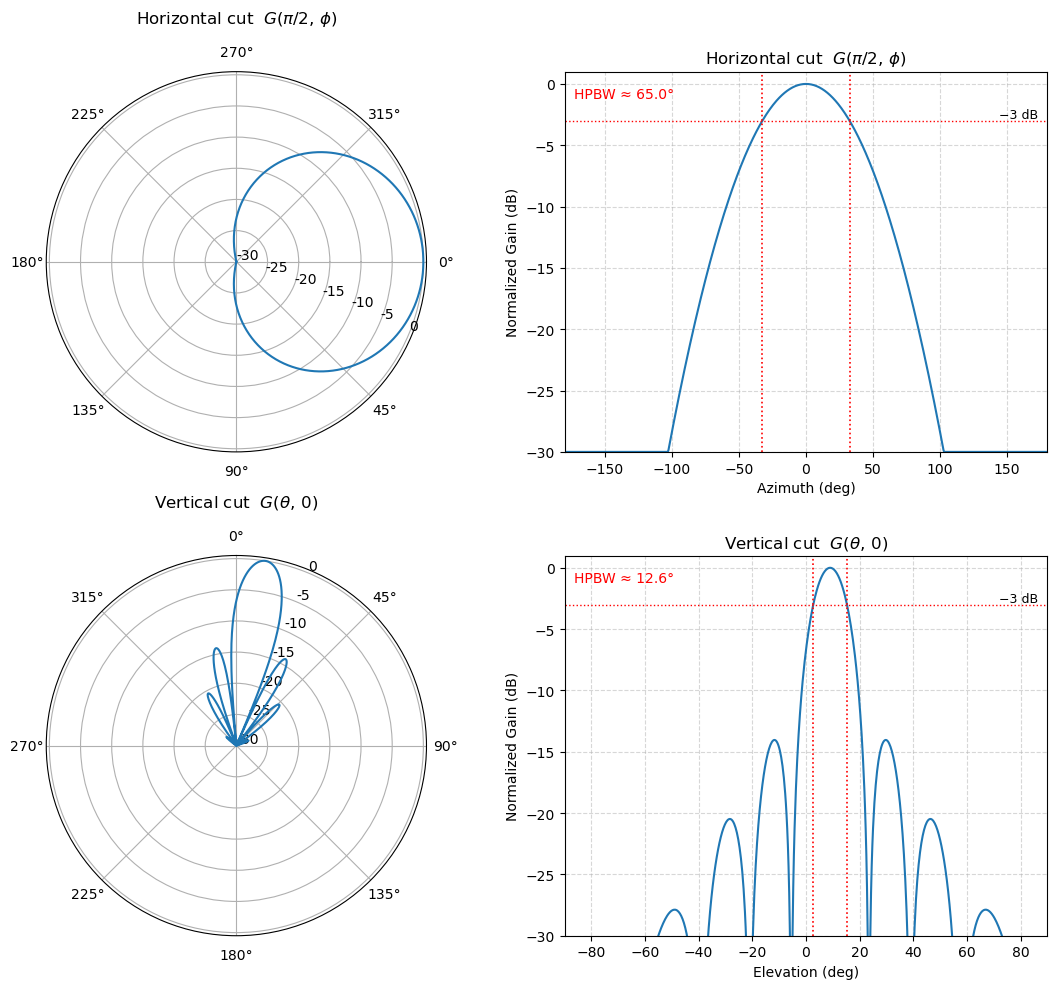

In [7]:
fig = plot_cuts_4up(H_angles, H_dB_rot, V_angles, V_dB_rot, floor_dB=-30)

In [8]:
def save_beamcuts_npz_min(path, H_angles, H_dB, H_lin, V_angles, V_dB, V_lin):
    np.savez_compressed(
        path,
        H_angles=np.asarray(H_angles, dtype=np.float32),
        H_dB=np.asarray(H_dB, dtype=np.float32),
        H_lin=np.asarray(H_lin, dtype=np.float32),
        V_angles=np.asarray(V_angles, dtype=np.float32),
        V_dB=np.asarray(V_dB, dtype=np.float32),
        V_lin=np.asarray(V_lin, dtype=np.float32),
    )

In [9]:
save_beamcuts_npz_min("beamcuts.npz", H_angles, H_dB, H_lin, V_angles, V_dB, V_lin)